# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Dict, Tuple, Optional
from dataclasses import dataclass
import json
from pathlib import Path


In [2]:
!pip install torch==2.4.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1

In [2]:
!pip install causal-conv1d mamba-ssm --no-build-isolation

  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 14.3 MB/s eta 0:00:00
  Created wheel for causal-conv1d: filename=causal_conv1d-1.5.3.post1-cp312-cp312-linux_x86_64.whl size=151299921 sha256=ede850c09efb608705781bd2ae44a41f291a8006d158a4d28f6746e5a67cb1e2
  Stored in directory: /root/.cache/pip/wheels/50/b5/ee/ccdfcb7fa5da6970cb61695a3486c1cb4126e7050785c73ba3
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.6.post3-cp312-cp312-linux_x86_64.whl size=533241749 sha256=11249c2f3c4d9c2f6d297382fc6a233591d115afe80d3f8d645f5a64102cc158
  Stored in directory: /root/.cache/pip/wheels/a9/66/b0/91003b49a34b45995d1b34c7fd2c70cd998a23560e66f6817a
Successfully built causal-conv1d mamba-ssm


# Mamba

In [3]:
@dataclass
class MambaConfig:
    """Configuration for Mamba model"""
    input_dim: int  # To be set based on data
    output_dim: int  # To be set based on data
    d_model: int = 256  # Hidden dimension
    n_layers: int = 4  # Number of Mamba layers
    d_state: int = 16  # SSM state dimension
    d_conv: int = 4  # Convolution kernel size
    expand_factor: int = 2  # Expansion factor for inner dimension
    dropout: float = 0.1

    def to_dict(self):
        return {k: v for k, v in self.__dict__.items()}


In [47]:
class MambaBlock(nn.Module):
    """Single Mamba block with state space model"""
    def __init__(self, config: MambaConfig):
        super().__init__()
        self.config = config

        # Try to import mamba_ssm, fallback to custom implementation if not available
        try:
            from mamba_ssm import Mamba
            self.mamba = Mamba(
                d_model=config.d_model,
                d_state=config.d_state,
                d_conv=config.d_conv,
                expand=config.expand_factor,
            )
        except ImportError:
            print("Warning: mamba_ssm not found. Using simplified SSM implementation.")
            self.mamba = self._create_simplified_ssm()

        self.norm = nn.LayerNorm(config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def _create_simplified_ssm(self):
        """Simplified state space model as fallback"""
        return nn.Sequential(
            nn.Linear(self.config.d_model, self.config.d_model * self.config.expand_factor),
            nn.GELU(),
            nn.Linear(self.config.d_model * self.config.expand_factor, self.config.d_model)
        )

    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        residual = x
        x = self.norm(x)
        x = self.mamba(x)
        x = self.dropout(x)
        return x + residual


class SEMGMambaModel(nn.Module):
    """Mamba model for sEMG signal translation"""
    def __init__(self, config: MambaConfig):
        super().__init__()
        self.config = config

        # Input projection (to be configured based on your data)
        self.input_projection = nn.Linear(config.input_dim, config.d_model)

        # Stack of Mamba blocks
        self.mamba_layers = nn.ModuleList([
            MambaBlock(config) for _ in range(config.n_layers)
        ])

        # Output projection (to be configured based on your data)
        self.output_projection = nn.Sequential(
          nn.LayerNorm(config.d_model),
          nn.Linear(config.d_model, config.output_dim),
          nn.Sigmoid()
      )


        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        """
        Args:
            x: Input sEMG signals, shape (batch, seq_len, input_dim)
        Returns:
            Output finger intent signals, shape (batch, seq_len, output_dim)
        """
        x = self.input_projection(x)
        x = self.dropout(x)

        # Pass through Mamba layers
        for layer in self.mamba_layers:
            x = layer(x)

        # Project to output dimension
        x = self.output_projection(x)

        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Getting data info

In [22]:
class SEMGDataset(Dataset):
    """Dataset for sEMG signals"""
    def __init__(self, input_signals, target_signals):
        """
        Args:
            input_signals: Hand-to-nose grasping sEMG (N, seq_len, input_dim)
            target_signals: Finger intent sEMG (N, seq_len, output_dim)
        """
        self.input_signals = torch.FloatTensor(input_signals)
        self.target_signals = torch.FloatTensor(target_signals)

    def __len__(self):
        return len(self.input_signals)

    def __getitem__(self, idx):
        return self.input_signals[idx], self.target_signals[idx]

    def denormalize_output(self, normalized_output):
        """
        Denormalizes output predictions using the global min/max values
        captured during data loading.
        """
        # Ensure global min/max are available
        if 'GLOBAL_MIN_TARGET' not in globals() or 'GLOBAL_MAX_TARGET' not in globals():
            print("Warning: Normalization parameters not found. Returning unscaled output.")
            return normalized_output

        min_target = GLOBAL_MIN_TARGET
        max_target = GLOBAL_MAX_TARGET

        denormalized_output = normalized_output * (max_target - min_target) + min_target
        return denormalized_output

# Training Loop

In [6]:
class SEMGTrainer:
    """Training loop for sEMG Mamba model"""
    def __init__(
        self,
        model: SEMGMambaModel,
        train_loader: DataLoader,
        val_loader: DataLoader,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-5,
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        self.criterion = nn.MSELoss()  # Can be changed to custom loss
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )

        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')

    def train_epoch(self) -> float:
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        for batch_idx, (inputs, targets) in enumerate(self.train_loader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        return avg_loss

    def validate(self) -> float:
        """Validate the model"""
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                num_batches += 1

        avg_loss = total_loss / num_batches
        return avg_loss

    def train(self, num_epochs: int, save_path: Optional[str] = None, verbose: bool = True) -> Dict:
        """Full training loop"""
        if verbose:
            print(f"Training on device: {self.device}")
            print(f"Model parameters: {self.model.count_parameters():,}")

        for epoch in range(num_epochs):
            train_loss = self.train_epoch()
            val_loss = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                if save_path:
                    self.save_checkpoint(save_path)
                    if verbose:
                        print(f"✓ Saved new best model (val_loss: {val_loss:.6f})")

            if verbose and (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1:3d}/{num_epochs} - "
                      f"Train: {train_loss:.6f}, Val: {val_loss:.6f}, "
                      f"LR: {self.optimizer.param_groups[0]['lr']:.2e}")

        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

    def save_checkpoint(self, path: str):
        """Save model checkpoint"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.model.config.to_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
        }, path)

    def load_checkpoint(self, path: str):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])


# Bayesian Optimization

In [9]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.8 MB/s eta 0:00:00


In [16]:
import json
from pathlib import Path
import optuna
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠ optuna not installed. Install with: pip install optuna")


class BayesianHPTuner:
    """Bayesian hyperparameter optimization using Optuna"""
    def __init__(self, train_data: Tuple[np.ndarray, np.ndarray], val_data: Tuple[np.ndarray, np.ndarray], input_dim: int, output_dim: int, n_trials: int = 50, device: str = 'cuda' if torch.cuda.is_available() else 'cpu', hp_epochs: int = 20):
      if not OPTUNA_AVAILABLE:
            raise ImportError("optuna is required for hyperparameter tuning")

      self.train_data = train_data
      self.val_data = val_data
      self.input_dim = input_dim
      self.output_dim = output_dim
      self.n_trials = n_trials
      self.device = device
      self.hp_epochs = hp_epochs
      self.best_params = None
      self.best_score = float('inf')
      self.study = None


    def objective(self, trial: optuna.Trial) -> float:
        """Objective function for Optuna"""

        # ========== HYPERPARAMETER SEARCH SPACE ==========

        # Model architecture hyperparameters
        config = MambaConfig(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            d_model=trial.suggest_categorical('d_model', [128, 256, 512]),
            n_layers=trial.suggest_int('n_layers', 2, 6),
            d_state=trial.suggest_categorical('d_state', [8, 16, 32]),
            d_conv=trial.suggest_categorical('d_conv', [2, 4, 8]),
            expand_factor=trial.suggest_categorical('expand_factor', [2, 4]),
            dropout=trial.suggest_float('dropout', 0.0, 0.3),
        )

        # Training hyperparameters
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        # ========== CREATE DATA LOADERS ==========
        train_dataset = SEMGDataset(*self.train_data)
        val_dataset = SEMGDataset(*self.val_data)

        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )

        # ========== CREATE AND TRAIN MODEL ==========
        model = SEMGMambaModel(config)
        trainer = SEMGTrainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=self.device,
            learning_rate=learning_rate,
            weight_decay=weight_decay
        )

        # Train for specified epochs with pruning
        for epoch in range(self.hp_epochs):
            train_loss = trainer.train_epoch()
            val_loss = trainer.validate()

            # Report intermediate value for pruning
            trial.report(val_loss, epoch)

            # Handle pruning based on intermediate value
            if trial.should_prune():
                raise optuna.TrialPruned()

        # Return final validation loss
        final_val_loss = trainer.validate()
        return final_val_loss

    def optimize(self, study_name: str = "semg_mamba_optimization") -> Dict:
        """Run Bayesian optimization"""

        print("="*70)
        print("STARTING BAYESIAN HYPERPARAMETER OPTIMIZATION")
        print("="*70)
        print(f"Number of trials: {self.n_trials}")
        print(f"Epochs per trial: {self.hp_epochs}")
        print(f"Device: {self.device}")
        print(f"Input dim: {self.input_dim}, Output dim: {self.output_dim}")
        print("="*70 + "\n")

        # Create study with TPE sampler and median pruner
        self.study = optuna.create_study(
            study_name=study_name,
            direction='minimize',
            sampler=optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(
                n_startup_trials=5,  # Don't prune first 5 trials
                n_warmup_steps=5     # Don't prune first 5 epochs
            )
        )

        # Run optimization
        self.study.optimize(
            self.objective,
            n_trials=self.n_trials,
            show_progress_bar=True,
            catch=(RuntimeError,)  # Catch CUDA OOM errors
        )

        self.best_params = self.study.best_params
        self.best_score = self.study.best_value

        # Print results
        self._print_results()

        return {
            'best_params': self.best_params,
            'best_score': self.best_score,
            'study': self.study
        }

    def _print_results(self):
        """Print optimization results"""
        print("\n" + "="*70)
        print("OPTIMIZATION COMPLETE!")
        print("="*70)
        print(f"\n{'BEST HYPERPARAMETERS:':^70}\n")
        print("-"*70)

        # Model architecture
        print("Model Architecture:")
        print(f"  d_model:        {self.best_params['d_model']}")
        print(f"  n_layers:       {self.best_params['n_layers']}")
        print(f"  d_state:        {self.best_params['d_state']}")
        print(f"  d_conv:         {self.best_params['d_conv']}")
        print(f"  expand_factor:  {self.best_params['expand_factor']}")
        print(f"  dropout:        {self.best_params['dropout']:.4f}")

        # Training hyperparameters
        print("\nTraining Hyperparameters:")
        print(f"  learning_rate:  {self.best_params['learning_rate']:.6f}")
        print(f"  weight_decay:   {self.best_params['weight_decay']:.6f}")
        print(f"  batch_size:     {self.best_params['batch_size']}")

        print("\nPerformance:")
        print(f"  Best Val Loss:  {self.best_score:.6f}")
        print(f"  Total Trials:   {len(self.study.trials)}")
        print(f"  Pruned Trials:  {len([t for t in self.study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

        print("="*70 + "\n")

    def get_best_config(self) -> MambaConfig:
        """Get best configuration from optimization"""
        if self.best_params is None:
            raise ValueError("Run optimize() first")

        return MambaConfig(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            d_model=self.best_params['d_model'],
            n_layers=self.best_params['n_layers'],
            d_state=self.best_params['d_state'],
            d_conv=self.best_params['d_conv'],
            expand_factor=self.best_params['expand_factor'],
            dropout=self.best_params['dropout'],
        )

    def save_results(self, output_dir: str = "./hp_results"):
        """Save optimization results"""
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)

        # Save best hyperparameters
        with open(output_path / 'best_hyperparameters.json', 'w') as f:
            json.dump(self.best_params, f, indent=2)

        # Save all trials
        trials_data = []
        for trial in self.study.trials:
            trials_data.append({
                'number': trial.number,
                'value': trial.value if trial.value is not None else None,
                'params': trial.params,
                'state': trial.state.name
            })

        with open(output_path / 'all_trials.json', 'w') as f:
            json.dump(trials_data, f, indent=2)

        print(f"✓ Results saved to {output_path}/")

    def plot_optimization_history(self):
        """Plot optimization history (requires optuna and matplotlib)"""
        if self.study is None:
            raise ValueError("Run optimize() first")

        try:
            import matplotlib.pyplot as plt

            fig = optuna.visualization.matplotlib.plot_optimization_history(self.study)
            plt.tight_layout()
            plt.savefig('optimization_history.png', dpi=150)
            print("✓ Saved optimization_history.png")

            fig = optuna.visualization.matplotlib.plot_param_importances(self.study)
            plt.tight_layout()
            plt.savefig('param_importances.png', dpi=150)
            print("✓ Saved param_importances.png")

        except ImportError:
            print("⚠ matplotlib not available for plotting")

# Sample Usage

In [45]:
import matplotlib.pyplot as plt
import torch

def plot_signal(
    x,
    name="signal",
    b=0,
    channels=(0, 1, 2),
    t0=0,
    t1=200,
    max_channels=12,
):
    """
    Plot selected channels over time for a single batch element.

    x: torch.Tensor with shape (B, T, C)
    channels: iterable of channel indices to plot
    """
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu()

    B, T, C = x.shape
    t1 = min(t1, T)
    channels = list(channels)[:max_channels]
    channels = [c for c in channels if 0 <= c < C]

    if len(channels) == 0:
        print(f"[plot_signal] No valid channels to plot for C={C}.")
        return

    ts = x[b, t0:t1, :]  # (t1-t0, C)

    plt.figure()
    for c in channels:
        plt.plot(ts[:, c].numpy(), label=f"ch{c}")
    plt.title(f"{name} | B={b}, T={t0}:{t1}, C={C}")
    plt.xlabel("time (index)")
    plt.ylabel("amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


[I 2026-01-10 19:45:34,368] A new study created in memory with name: semg_mamba_hp



STEP 1: LOADING DATA
⚠ Using SMALL dummy data for debugging!
Train samples: 1, Val samples: 1
Target min/max (train): -148.23, 129.88
✓ Data loaded successfully
  Train: 1 samples, 100 timesteps
  Val:   1 samples, 100 timesteps
  Input channels:  3
  Output channels: 5

STEP 2: HYPERPARAMETER OPTIMIZATION
STARTING BAYESIAN HYPERPARAMETER OPTIMIZATION
Number of trials: 5
Epochs per trial: 5
Device: cuda
Input dim: 3, Output dim: 5



  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-10 19:45:34,521] Trial 0 finished with value: 0.04618484154343605 and parameters: {'d_model': 256, 'n_layers': 4, 'd_state': 8, 'd_conv': 2, 'expand_factor': 4, 'dropout': 0.2497327922401265, 'learning_rate': 4.335281794951564e-05, 'weight_decay': 3.5113563139704077e-06, 'batch_size': 64}. Best is trial 0 with value: 0.04618484154343605.
[I 2026-01-10 19:45:34,617] Trial 1 finished with value: 0.041801705956459045 and parameters: {'d_model': 512, 'n_layers': 2, 'd_state': 32, 'd_conv': 2, 'expand_factor': 2, 'dropout': 0.1822634555704315, 'learning_rate': 3.247673570627447e-05, 'weight_decay': 1.5673095467235414e-06, 'batch_size': 32}. Best is trial 1 with value: 0.041801705956459045.
[I 2026-01-10 19:45:34,846] Trial 2 finished with value: 0.04949536547064781 and parameters: {'d_model': 512, 'n_layers': 4, 'd_state': 16, 'd_conv': 2, 'expand_factor': 4, 'dropout': 0.16401308380298388, 'learning_rate': 3.585612610345396e-05, 'weight_decay': 0.0008105016126411582, 'batch_size

/tmp/ipython-input-2445380480.py:211: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(self.study)


✓ Saved optimization_history.png


/tmp/ipython-input-2445380480.py:216: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(self.study)


✓ Saved param_importances.png

STEP 3: TRAINING FINAL MODEL
✓ Model created with 3,491,333 parameters
Training on device: cuda
Model parameters: 3,491,333
✓ Saved new best model (val_loss: 0.058831)
✓ Saved new best model (val_loss: 0.058369)
✓ Saved new best model (val_loss: 0.057914)
✓ Saved new best model (val_loss: 0.057459)
✓ Saved new best model (val_loss: 0.057006)
Epoch   5/400 - Train: 0.055106, Val: 0.057006, LR: 3.25e-05
✓ Saved new best model (val_loss: 0.056554)
✓ Saved new best model (val_loss: 0.056105)
✓ Saved new best model (val_loss: 0.055660)
✓ Saved new best model (val_loss: 0.055221)
✓ Saved new best model (val_loss: 0.054790)
Epoch  10/400 - Train: 0.054519, Val: 0.054790, LR: 3.25e-05
✓ Saved new best model (val_loss: 0.054368)
✓ Saved new best model (val_loss: 0.053949)
✓ Saved new best model (val_loss: 0.053538)
✓ Saved new best model (val_loss: 0.053129)
✓ Saved new best model (val_loss: 0.052724)
Epoch  15/400 - Train: 0.051395, Val: 0.052724, LR: 3.25e-05
✓ 

/tmp/ipython-input-1394780174.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)


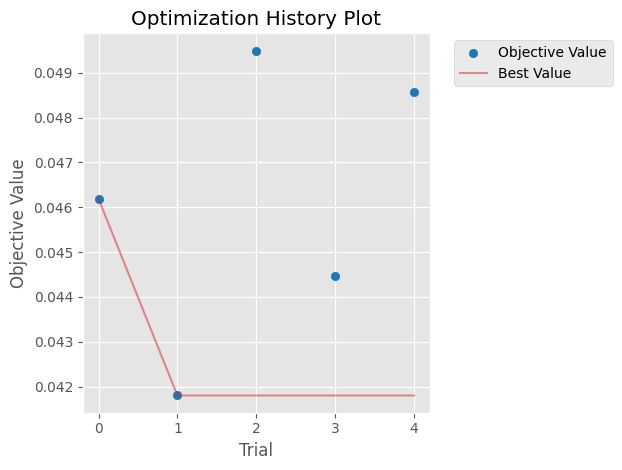

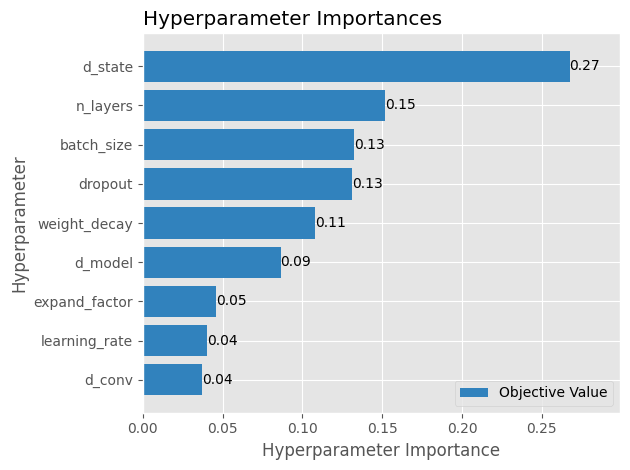

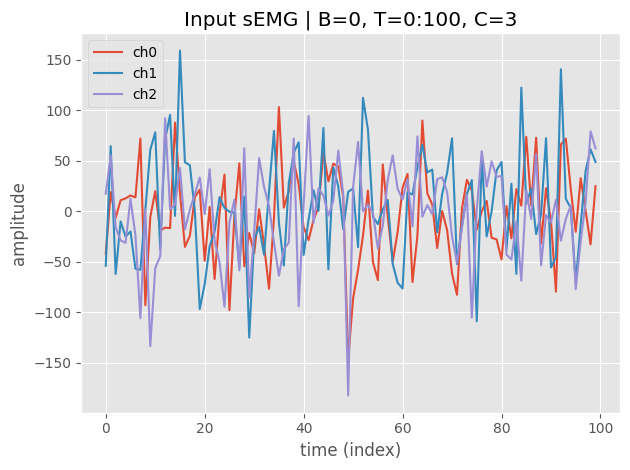

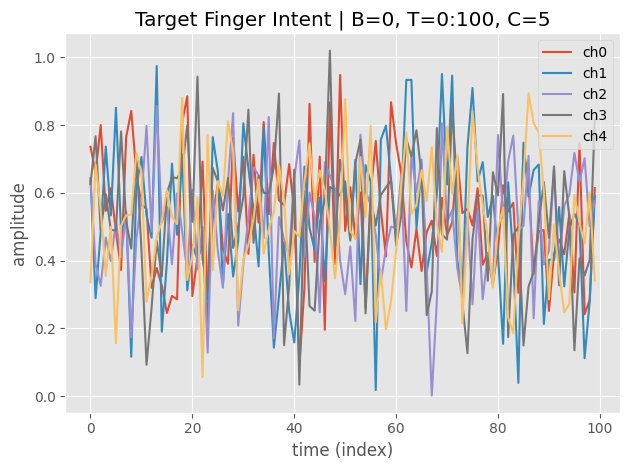

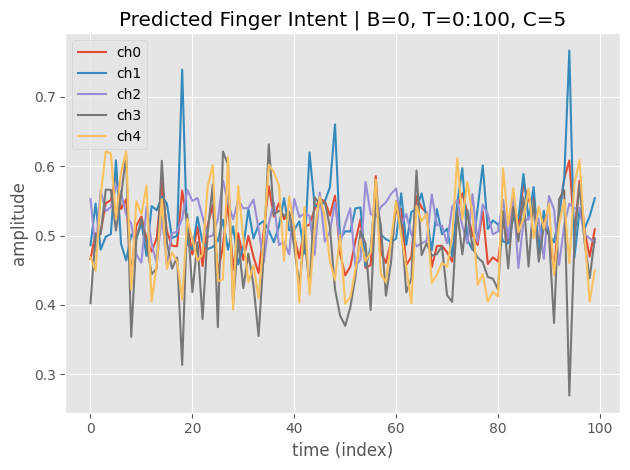

In [50]:
def load_your_semg_data(seed=42):
    print("⚠ Using SMALL dummy data for debugging!")

    rng = np.random.default_rng(seed)

    num_train = 1
    num_val = 1
    seq_len = 100
    input_dim = 3
    output_dim = 5

    train_input = rng.standard_normal((num_train, seq_len, input_dim)) * 50
    train_target = rng.standard_normal((num_train, seq_len, output_dim)) * 50
    val_input = rng.standard_normal((num_val, seq_len, input_dim)) * 50
    val_target = rng.standard_normal((num_val, seq_len, output_dim)) * 50

    min_target = np.min(train_target)
    max_target = np.max(train_target)
    denom = (max_target - min_target) + 1e-8

    train_target_normalized = (train_target - min_target) / denom
    val_target_normalized   = (val_target   - min_target) / denom

    global GLOBAL_MIN_TARGET, GLOBAL_MAX_TARGET
    GLOBAL_MIN_TARGET = min_target
    GLOBAL_MAX_TARGET = max_target

    print(f"Train samples: {num_train}, Val samples: {num_val}")
    print(f"Target min/max (train): {min_target:.2f}, {max_target:.2f}")

    return train_input, train_target_normalized, val_input, val_target_normalized

def complete_pipeline(
    n_hp_trials: int = 30,
    hp_epochs: int = 20,
    final_epochs: int = 100,
    output_dir: str = "./semg_mamba_results"
):
    """
    Complete pipeline: Data Loading -> HP Tuning -> Final Training -> Inference

    Args:
        n_hp_trials: Number of hyperparameter optimization trials
        hp_epochs: Epochs per trial during HP search
        final_epochs: Epochs for final model training
        output_dir: Directory to save results
    """

    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # ==================== STEP 1: LOAD DATA ====================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)

    train_input, train_target, val_input, val_target = load_your_semg_data()

    input_dim = train_input.shape[2]
    output_dim = train_target.shape[2]

    print(f"✓ Data loaded successfully")
    print(f"  Train: {train_input.shape[0]} samples, {train_input.shape[1]} timesteps")
    print(f"  Val:   {val_input.shape[0]} samples, {val_input.shape[1]} timesteps")
    print(f"  Input channels:  {input_dim}")
    print(f"  Output channels: {output_dim}")

    # ==================== STEP 2: HYPERPARAMETER TUNING ====================
    print("\n" + "="*70)
    print("STEP 2: HYPERPARAMETER OPTIMIZATION")
    print("="*70)

    tuner = BayesianHPTuner(
        train_data=(train_input, train_target),
        val_data=(val_input, val_target),
        input_dim=input_dim,
        output_dim=output_dim,
        n_trials=n_hp_trials,
        hp_epochs=hp_epochs
    )

    hp_results = tuner.optimize(study_name="semg_mamba_hp")
    tuner.save_results(output_dir=str(output_path))

    # Try to plot if matplotlib available
    try:
        tuner.plot_optimization_history()
    except:
        pass

    best_config = tuner.get_best_config()
    best_hp = tuner.best_params

    # ==================== STEP 3: TRAIN FINAL MODEL ====================
    print("\n" + "="*70)
    print("STEP 3: TRAINING FINAL MODEL")
    print("="*70)

    # Create datasets with best batch size
    train_dataset = SEMGDataset(train_input, train_target)
    val_dataset = SEMGDataset(val_input, val_target)

    train_loader = DataLoader(
        train_dataset,
        batch_size=best_hp['batch_size'],
        shuffle=True,
        num_workers=0
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=best_hp['batch_size'],
        shuffle=False,
        num_workers=0
    )

    # Create final model
    final_model = SEMGMambaModel(best_config)
    print(f"✓ Model created with {final_model.count_parameters():,} parameters")

    # Create trainer with best hyperparameters
    trainer = SEMGTrainer(
        model=final_model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=best_hp['learning_rate'],
        weight_decay=best_hp['weight_decay']
    )

    # Train final model
    save_path = str(output_path / 'best_semg_mamba_model.pt')
    training_results = trainer.train(
        num_epochs=final_epochs,
        save_path=save_path,
        verbose=True
    )

    print(f"\n✓ Training complete!")
    print(f"  Best validation loss: {training_results['best_val_loss']:.6f}")
    print(f"  Model saved to: {save_path}")

    # ==================== STEP 4: SAVE TRAINING HISTORY ====================
    history_path = output_path / 'training_history.json'
    with open(history_path, 'w') as f:
        json.dump({
            'train_losses': training_results['train_losses'],
            'val_losses': training_results['val_losses'],
            'best_val_loss': training_results['best_val_loss'],
            'config': best_config.to_dict(),
            'hyperparameters': best_hp
        }, f, indent=2)

    print(f"✓ Training history saved to: {history_path}")

    # ==================== STEP 5: INFERENCE EXAMPLE ====================
    print("\n" + "="*70)
    print("STEP 4: INFERENCE EXAMPLE")
    print("="*70)

    # Load best model
    trainer.load_checkpoint(save_path)
    final_model.eval()

    # Run inference on validation set
    with torch.no_grad():
        # Take first 5 samples from validation
        test_input = torch.FloatTensor(val_input[:5])
        test_target = torch.FloatTensor(val_target[:5])

        predictions = final_model(test_input.to(trainer.device))
        predictions = predictions.cpu()

        # Denormalize if needed
        predictions_denorm = val_dataset.denormalize_output(predictions)
        test_target_denorm = val_dataset.denormalize_output(test_target) # Also denormalize target for fair comparison

        # Calculate MSE for these samples using denormalized values
        mse = torch.nn.functional.mse_loss(predictions_denorm, test_target_denorm)

        print(f"✓ Inference successful on {len(test_input)} samples")
        print(f"  Input shape:       {test_input.shape}")
        print(f"  Prediction shape:  {predictions.shape}")
        print(f"  Test MSE (Denormalized): {mse.item():.6f}")

    # ==================== SUMMARY ====================
    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("="*70)
    print(f"\nResults saved to: {output_path}/")
    print("Files created:")
    print(f"  - best_semg_mamba_model.pt       (trained model)")
    print(f"  - best_hyperparameters.json      (best HP configuration)")
    print(f"  - all_trials.json                (all HP trials)")
    print(f"  - training_history.json          (training curves)")

    debug_inputs, debug_targets = next(iter(val_loader))
    debug_batch = (debug_inputs.cpu(), debug_targets.cpu())
    return final_model, trainer, hp_results, training_results, debug_batch


# ==================== SIMPLE USAGE FUNCTION ====================

def quick_train_without_hp_tuning(
    train_input: np.ndarray,
    train_target: np.ndarray,
    val_input: np.ndarray,
    val_target: np.ndarray,
    num_epochs: int = 50,
    save_path: str = 'quick_model.pt'
):
    """
    Quick training WITHOUT hyperparameter tuning (uses default config)
    Use this if you just want to train quickly without optimization
    """

    input_dim = train_input.shape[2]
    output_dim = train_target.shape[2]

    # Create datasets
    train_dataset = SEMGDataset(train_input, train_target)
    val_dataset = SEMGDataset(val_input, val_target)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Create model with default config
    config = MambaConfig(
        input_dim=input_dim,
        output_dim=output_dim,
        d_model=256,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand_factor=2,
        dropout=0.1
    )

    model = SEMGMambaModel(config)

    # Train
    trainer = SEMGTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=1e-3
    )

    results = trainer.train(num_epochs=num_epochs, save_path=save_path)

    return model, trainer, results


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    model, trainer, hp_results, train_results, debug_batch = complete_pipeline(
        n_hp_trials=5,
        hp_epochs=5,
        final_epochs=400,
        output_dir="./semg_mamba_results"
    )

    model.eval()
    inputs, targets = debug_batch
    inputs = inputs.to(trainer.device)

    with torch.no_grad():
        predictions = model(inputs).cpu()

    print("targets min/max:", targets.min().item(), targets.max().item())
    print("preds   min/max:", predictions.min().item(), predictions.max().item())

    plot_signal(inputs.cpu(), name="Input sEMG", b=0, channels=(0,1,2), t0=0, t1=100)
    plot_signal(targets, name="Target Finger Intent", b=0, channels=range(targets.shape[-1]), t0=0, t1=100)
    plot_signal(predictions, name="Predicted Finger Intent", b=0, channels=range(predictions.shape[-1]), t0=0, t1=100)


    # OPTION 2: Quick training without HP tuning (uncomment to use)
    """
    print("Running quick training without HP optimization...\n")

    train_input, train_target, val_input, val_target = load_your_semg_data()

    model, trainer, results = quick_train_without_hp_tuning(
        train_input, train_target, val_input, val_target,
        num_epochs=50,
        save_path='quick_semg_model.pt'
    )
    """

/tmp/ipython-input-2064121853.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


⚠ Using SMALL dummy data for debugging!
Train samples: 1, Val samples: 1
Target min/max (train): -148.23, 129.88
Sample inputs shape: torch.Size([1, 100, 3])
Sample targets shape: torch.Size([1, 100, 5])
Sample predictions shape: torch.Size([1, 100, 5])
targets min/max: 0.0016018858877941966 1.0203286409378052
preds   min/max: 0.21774914860725403 0.8001999258995056


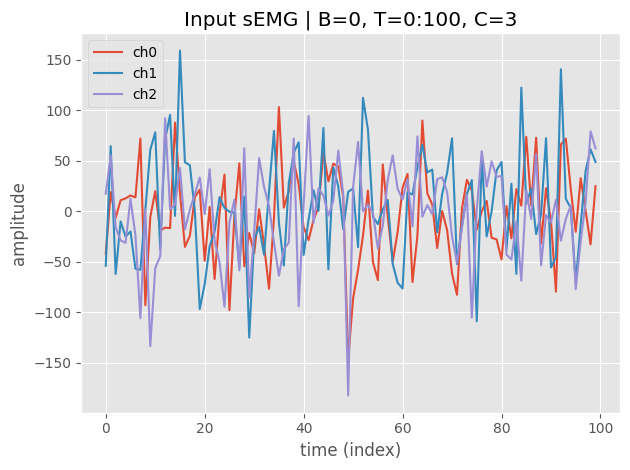

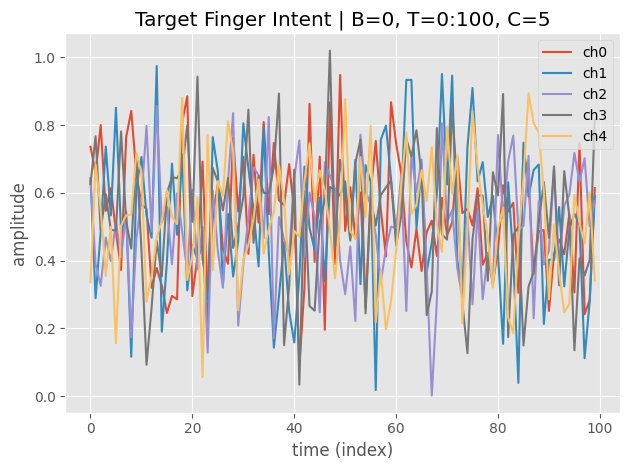

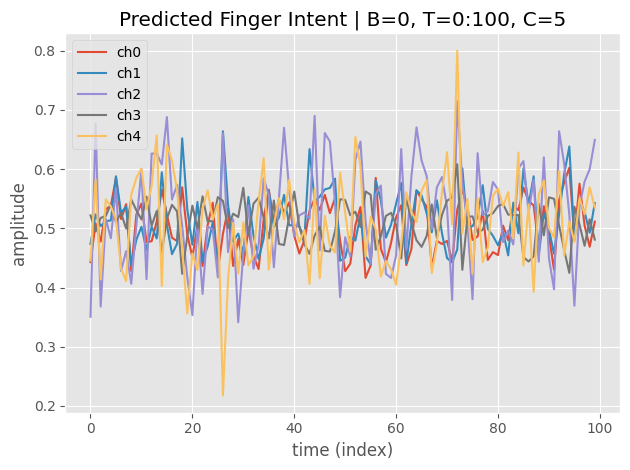

Visualization complete. Check the plots above.


In [49]:
# Load the best model for inference
checkpoint_path = "./semg_mamba_results/best_semg_mamba_model.pt"
inferrer = SEMGInference.from_checkpoint(checkpoint_path)

# Prepare data for visualization
# Re-load dummy data to ensure we have a val_loader
# In a real scenario, you would use your actual test/validation data
_, _, val_input_np, val_target_np = load_your_semg_data()
val_dataset_for_viz = SEMGDataset(val_input_np, val_target_np)
val_loader_for_viz = DataLoader(val_dataset_for_viz, batch_size=4, shuffle=False)

# Get an example batch of inputs, targets, and predictions
inputs, targets, predictions = inferrer.get_example_input_output(val_loader_for_viz)

print(f"Sample inputs shape: {inputs.shape}")
print(f"Sample targets shape: {targets.shape}")
print(f"Sample predictions shape: {predictions.shape}")

# Visualize the first sample (batch_idx=0)
batch_idx_to_plot = 0

print("targets min/max:", targets.min().item(), targets.max().item())
print("preds   min/max:", predictions.min().item(), predictions.max().item())


# Plot input signals (e.g., first 3 channels)
plot_signal(inputs, name="Input sEMG", b=batch_idx_to_plot, channels=(0, 1, 2))

# Plot target signals (e.g., all 5 channels if output_dim is 5)
plot_signal(targets, name="Target Finger Intent", b=batch_idx_to_plot, channels=range(targets.shape[-1]))

# Plot predicted signals (e.g., all 5 channels)
plot_signal(predictions, name="Predicted Finger Intent", b=batch_idx_to_plot, channels=range(predictions.shape[-1]))

print("Visualization complete. Check the plots above.")


# Inference

In [51]:
class SEMGInference:
    """Utilities for inference and evaluation"""

    def __init__(self, model: SEMGMambaModel, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.model.eval()
        self.device = device

    @torch.no_grad()
    def predict(self, input_signals: np.ndarray) -> np.ndarray:
        """
        Run inference on input signals

        Args:
            input_signals: (num_samples, seq_len, input_dim) or (seq_len, input_dim)
        Returns:
            predictions: Same shape but with output_dim
        """
        # Handle single sample
        single_sample = False
        if input_signals.ndim == 2:
            input_signals = input_signals[np.newaxis, :]
            single_sample = True

        # Convert to tensor
        inputs = torch.FloatTensor(input_signals).to(self.device)

        # Predict
        predictions = self.model(inputs).cpu().numpy()

        # Return single sample if input was single
        if single_sample:
            predictions = predictions[0]

        return predictions

    @torch.no_grad()
    def evaluate(self, test_loader: DataLoader) -> Dict:
        """Evaluate model on test set"""
        total_mse = 0.0
        total_mae = 0.0
        num_batches = 0

        for inputs, targets in test_loader:
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)

            outputs = self.model(inputs)

            mse = torch.nn.functional.mse_loss(outputs, targets)
            mae = torch.nn.functional.l1_loss(outputs, targets)

            total_mse += mse.item()
            total_mae += mae.item()
            num_batches += 1

        return {
            'mse': total_mse / num_batches,
            'mae': total_mae / num_batches,
            'rmse': np.sqrt(total_mse / num_batches)
        }

    @torch.no_grad()
    def get_example_input_output(self, data_loader: DataLoader) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves one batch of input, target, and model predictions from a DataLoader.

        Args:
            data_loader: DataLoader (e.g., validation or test loader).

        Returns:
            A tuple containing:
            - inputs: The input tensor for the batch.
            - targets: The target tensor for the batch.
            - predictions: The model's prediction tensor for the batch.
        """
        # Get one batch from the data loader
        inputs, targets = next(iter(data_loader))

        inputs = inputs.to(self.device)
        targets = targets.to(self.device)

        # Get model predictions
        predictions = self.model(inputs)

        return inputs.cpu(), targets.cpu(), predictions.cpu()


    @classmethod
    def from_checkpoint(cls, checkpoint_path: str, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Load model from checkpoint
        """
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Reconstruct config
        config_dict = checkpoint['config']
        config = MambaConfig(**config_dict)

        # Create model and load weights
        model = SEMGMambaModel(config)
        model.load_state_dict(checkpoint['model_state_dict'])

        return cls(model, device)

/tmp/ipython-input-2064121853.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


⚠ Using SMALL dummy data for debugging!
Train samples: 1, Val samples: 1
Target min/max (train): -148.23, 129.88
Sample inputs shape: torch.Size([1, 100, 3])
Sample targets shape: torch.Size([1, 100, 5])
Sample predictions shape: torch.Size([1, 100, 5])


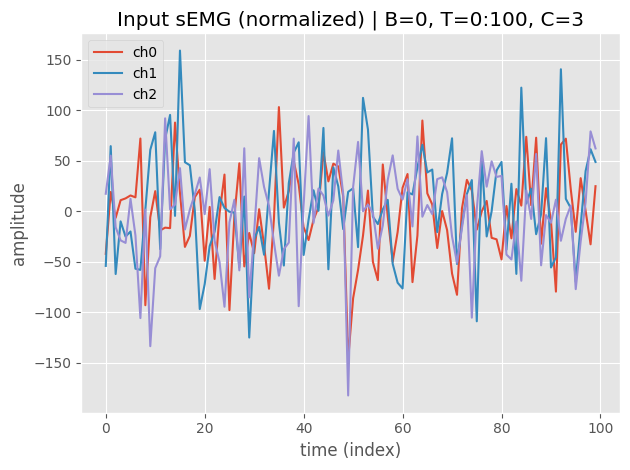

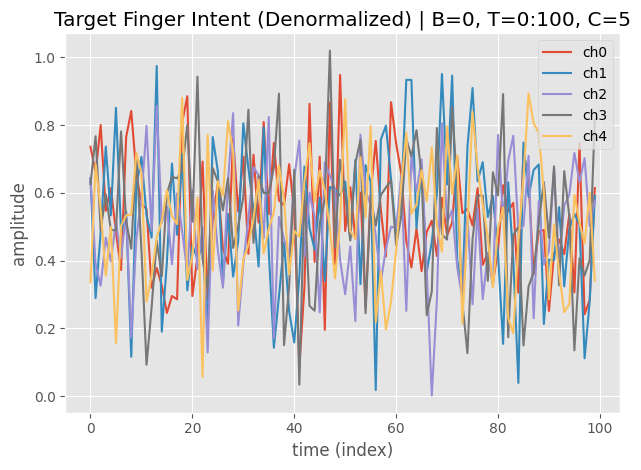

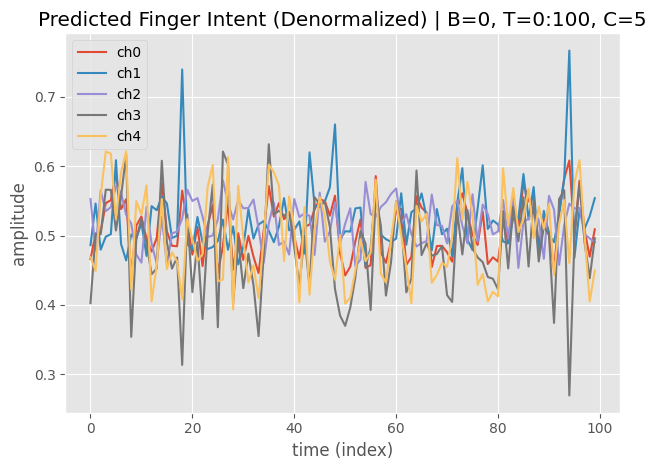

Visualization complete. Check the plots above.


In [52]:
import matplotlib.pyplot as plt
import torch

# Load the best model for inference
checkpoint_path = "./semg_mamba_results/best_semg_mamba_model.pt"
inferrer = SEMGInference.from_checkpoint(checkpoint_path)

# Prepare data for visualization
# Re-load dummy data to ensure we have a val_loader
# In a real scenario, you would use your actual test/validation data
_, _, val_input_np, val_target_np = load_your_semg_data()
val_dataset_for_viz = SEMGDataset(val_input_np, val_target_np)
val_loader_for_viz = DataLoader(val_dataset_for_viz, batch_size=4, shuffle=False)

# Get an example batch of inputs, targets, and predictions
inputs, targets, predictions = inferrer.get_example_input_output(val_loader_for_viz)

print(f"Sample inputs shape: {inputs.shape}")
print(f"Sample targets shape: {targets.shape}")
print(f"Sample predictions shape: {predictions.shape}")

# Visualize the first sample (batch_idx=0)
batch_idx_to_plot = 0

# Denormalize predictions and targets for plotting
predictions_denorm = val_dataset_for_viz.denormalize_output(predictions)
targets_denorm = val_dataset_for_viz.denormalize_output(targets)

# Plot input signals (e.g., first 3 channels)
plot_signal(inputs, name="Input sEMG (normalized)", b=batch_idx_to_plot, channels=(0, 1, 2))

# Plot target signals (e.g., all 5 channels if output_dim is 5)
plot_signal(targets_denorm, name="Target Finger Intent (Denormalized)", b=batch_idx_to_plot, channels=range(targets_denorm.shape[-1]))

# Plot predicted signals (e.g., all 5 channels)
plot_signal(predictions_denorm, name="Predicted Finger Intent (Denormalized)", b=batch_idx_to_plot, channels=range(predictions_denorm.shape[-1]))

print("Visualization complete. Check the plots above.")
